## 1. Reading the dataset:

In [1]:
# Load dataset
import pandas as pd

df = pd.read_csv('./IMDB-Dataset.csv')

# Remove duplicate rows
df = df.drop_duplicates()

## 2. Data preprocessing:

In [3]:
!pip install nltk

  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached tqdm-4.66.5-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   --------------------------- ------------ 1.0/1.5 MB 8.5 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 5.3 MB/s eta 0:00:00
Using cached click-8.1.7-py3-none-any.whl (97 kB)
Using cached tqdm-4.66.5-py3-none-any.whl (78 kB)


In [5]:
!pip install contractions

In [7]:
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions

stop = set(stopwords.words('english'))

# Expanding contractions
def expand_contractions(text):
    return contractions.fix(text)

# Function to clean data
def preprocess_text(text):

    wl = WordNetLemmatizer()

    soup = BeautifulSoup(text, "html.parser") # Removing html tags
    text = soup.get_text()
    text = expand_contractions(text) # Expanding chatwords and contracts clearing contractions
    emoji_clean = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'', text)
    text = re.sub(r'\.(?=\S)', '. ', text) # add space after full stop
    text = re.sub(r'http\S+', '', text) # remove urls
    text = " ".join([
        word.lower() for word in text if word not in string.punctuation
    ]) # remove punctuation and make text lowercase
    text = " ".join([
        wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()]) # lemmatize
    return text

df['review'] = df['review'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\phida\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\phida\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [23]:
y_data

array([1, 1, 1, ..., 0, 0, 0])

## 3. Data analysis:

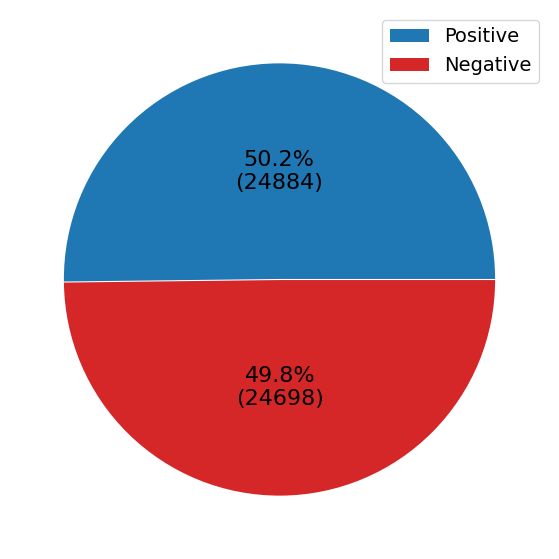

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct/100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

freq_pos = len(df[df['sentiment'] == 'positive'])
freq_neg = len(df[df['sentiment'] == 'negative'])

data = [freq_pos, freq_neg]

labels = ['positive', 'negative']
# Create pie chart
pie, ax = plt.subplots(figsize=[11,7])
plt.pie(x=data, autopct=lambda pct: func(pct, data), explode=[0.0025]*2, pctdistance=0.5, colors=[sns.color_palette()[0], 'tab:red'], textprops={'fontsize': 16})
# plt.title('Frequencies of sentiment labels', fontsize=14, fontweight='bold')
labels = [r'Positive', r'Negative']
plt.legend(labels, loc="best", prop={'size': 14})
pie.savefig("PieChart.png")
plt.show()

## 4. Word length analysis:

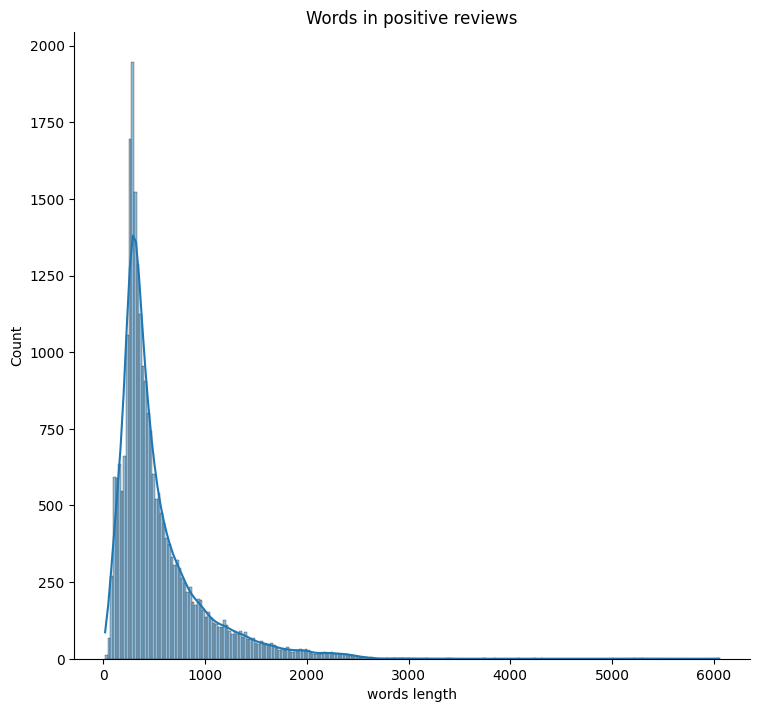

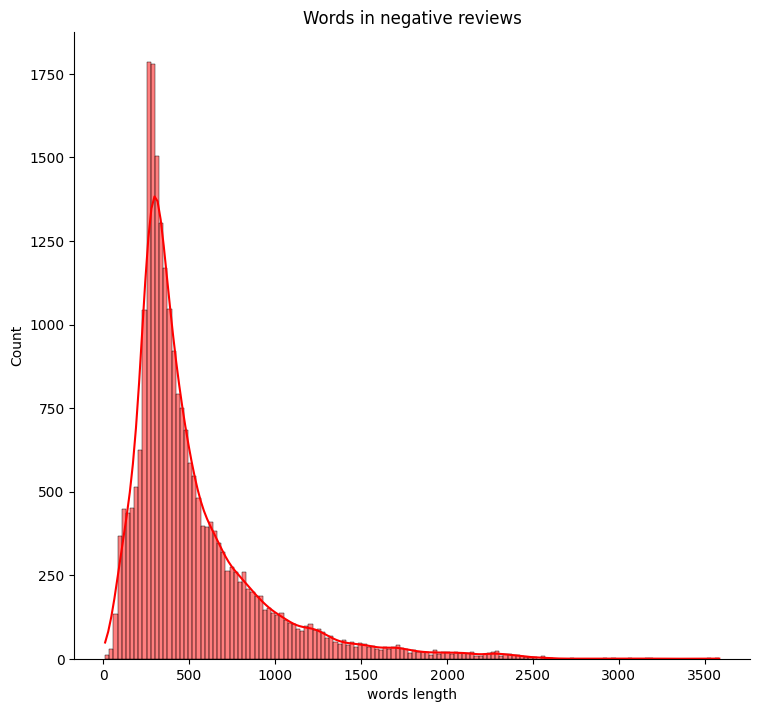

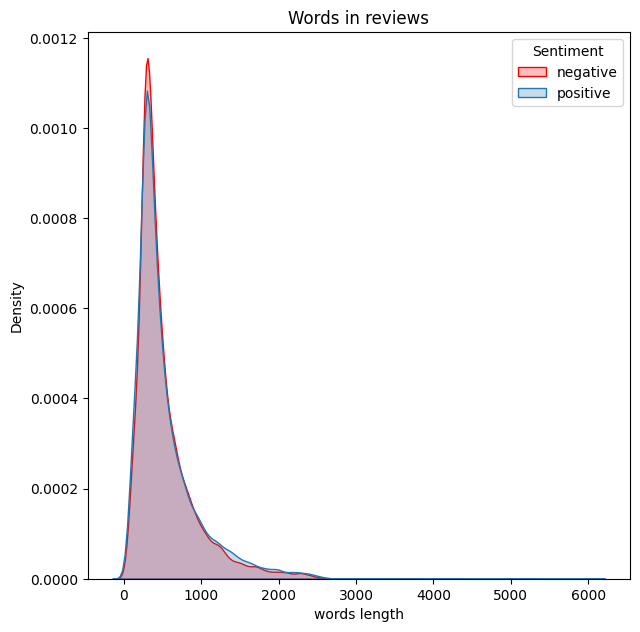

In [9]:
words_len = df['review'].str.split().map(lambda x: len(x))
df_temp = df.copy()
df_temp['words length'] = words_len

hist_positive = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'positive'],
    x="words length", hue="sentiment", kde=True, height=7, aspect=1.1, legend=False
).set(title='Words in positive reviews')
plt.show(hist_positive)

hist_negative = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'negative'],
    x="words length", hue="sentiment", kde=True, height=7, aspect=1.1, legend=False, palette=['red']
).set(title='Words in negative reviews')
plt.show(hist_negative)

plt.figure(figsize=(7,7.1))
kernel_distibution_number_words_plot = sns.kdeplot(
    data=df_temp, x="words length", hue="sentiment", fill=True, palette=[sns.color_palette()[0], 'red']
).set(title='Words in reviews')
plt.legend(title='Sentiment', labels=['negative', 'positive'])
plt.show(kernel_distibution_number_words_plot)

## 5. Splitting train and test data:

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder 

label_encode = LabelEncoder()
x_data = df["preprocessed_review"]
y_data = label_encode.fit_transform(df['sentiment'])

x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)

## 6. Text vectorization:

In [24]:
def preprocess_text(text):
    wl = WordNetLemmatizer()
    
    # Remove HTML tags
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    
    # Expand contractions
    text = contractions.fix(text)
    
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Convert to lowercase and remove punctuation
    text = "".join([char.lower() for char in text if char not in string.punctuation])
    
    # Tokenize, remove stopwords, and lemmatize
    words = text.split()
    words = [wl.lemmatize(word) for word in words if word not in stop]
    
    # Ensure at least one word remains
    if not words:
        words = ['neutral']  # Add a neutral word if all words were removed
    
    return " ".join(words)
    
# Apply preprocessing
df['preprocessed_review'] = df['review'].apply(preprocess_text)

In [26]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(x_train, y_train)

x_train_encoded = tfidf_vectorizer.transform(x_train)
x_test_encoded = tfidf_vectorizer.transform(x_test)

ValueError: empty vocabulary; perhaps the documents only contain stop words

## 7. Training and evaluating models:

### Decision Tree:

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

dt_classifier = DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)
dt_classifier.fit(x_train_encoded, y_train)
y_pred = dt_classifier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)

### Random Forest:

In [ ]:
rf_classifier = RandomForestClassifier(
    random_state=42
)
rf_classifier.fit(x_train_encoded, y_train)
y_pred = rf_classifier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)